In [1]:
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from Snowball import *
from tools import *
from getData import *
from plot import *


# 对某个雪球产品进行回测
def backtest(snowball, index_data_all):
    # 回测结果
    snowball.process_backtest(index_data_all)

    # 输出
    result_series = pd.Series((
        snowball.time_dynamic_param['start_date'],
        snowball.start_price,
        snowball.time_dynamic_param['end_date'],
        snowball.end_price,
        snowball.knockin_date,
        snowball.knockin_price,
        snowball.knockout_date,
        snowball.knockout_price,
        snowball.status,
        snowball.terminal_month,
        snowball.abs_return,
        snowball.annual_return,
        snowball.maturity_sign  
    ))
    return result_series


if __name__ == "__main__":

    ##########################################################################
    # 仅修改这部分参数设置 #####################################################
    ##########################################################################

    # ---------------------------- 雪球参数设置 ------------------------------#
    underlying = "上证50"
    underlying_code = "000016.SH"

    snowball_type = "限亏止盈型雪球"

    # 合约期限
    option_expire_month = 24                            # 只以月度来结算，一年则调整为12个月

    # 敲入条件
    knockin_barrier = 0.8                               # 敲入条件，敲入观察日的价格/起初价格

    # 敲出条件
    knockout_barrier = 1.02                             # 敲出条件，首个敲出观察日的价格/起初价格
    knockout_freq_month = 1                             # 敲出观察频率为每月

    # 票息设置
    kickout_coupon = 0.12                               # 敲出票息，提前敲出
    regular_coupon = 0.12                               # 红利票息，持有直到到期
    observation_start_month = 3                         # 首个敲出观察日为距离观察起始日后的第x月

    # 追保设置
    margin_call = False     # 不允许追保

    # ---------------------------- 回测参数设置 ------------------------------#
    backtest_start = ensure_trading_day(datetime(2018, 1, 1, 0, 0).date())
    backtest_end = ensure_trading_day(datetime(2021, 4, 1, 0, 0).date())

    # ---------------------------- 输出路径设置 ------------------------------#
    output_path = "D:/10-国君\GTJA-intern-codes/backtest_version_V2\output"

    ##########################################################################
    ##########################################################################
    ##########################################################################

    # 生成参数 ################################################################
    # 生成固定配置
    time_fixed_param = {'option_expire_month': option_expire_month}
    knockin_param = {'knockin_barrier': knockin_barrier}
    knockout_param = {'observation_start_month': observation_start_month,
                      'knockout_barrier': knockout_barrier,
                      'knockout_freq_month': knockout_freq_month}
    coupon_param = {'kickout_coupon': kickout_coupon,
                    'regular_coupon': regular_coupon}
    profit_param = {'margin_call': margin_call}

    # 生成回测区间
    trading_datelist = get_trading_datelist()
    backtest_datelist = [i for i in trading_datelist if i >= backtest_start
                         and i <= backtest_end]


    # 输出回测结果 #########################################################
    # 获取标的价格信息 
    index_data_all = get_underlying_data(underlying, 
                                         pd.to_datetime("2010-01-01").date(), 
                                         pd.to_datetime("2023-10-01").date())

    # data = index_data_all.loc[backtest_start:]
    # for i in range(1, len(data)):
    #     data.iloc[i, 0] = data.loc[backtest_start, 'close'] - 5 * i
        
    # 初始化雪球类
    snowball = SnowballOption.create_snowball(snowball_type, underlying,
                                                     time_fixed_param, knockin_param, knockout_param, coupon_param, profit_param)
    
    # 雪球基础信息输出
    plot_bactest_info(snowball, backtest_start, backtest_end, output_path)

    # 输出结果
    output = []
    for start_date in tqdm(backtest_datelist):
        
        # 设置雪球合约时间参数
        end_date = ensure_trading_day(start_date + relativedelta(months = snowball.time_fixed_param["option_expire_month"]))
        time_dynamic_param = {'start_date': start_date,  'end_date': end_date}

        # 初始化雪球类
        snowball.set_time_param(time_dynamic_param)
        snowball.reset_state()

        # 回测
        # output.append(backtest(snowball, data))
        # print(snowball.knockout_param["knockout_barrier"])
        output.append(backtest(snowball, index_data_all))

    col_names = ['初始日期',  '初始指数',  '到期日期', '到期指数', '敲入日期', 
                 '敲入点位', '敲出日期', '敲出点位', '敲入敲出状态', '敲出所需时间（月）',  
                 '绝对收益率', '年化收益率', '完成周期']
    output = pd.concat(output, axis=1).T 
    output.columns = col_names

    # output.to_csv(output_path + "/output.csv")


Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


100%|██████████| 789/789 [00:01<00:00, 512.35it/s]


In [2]:
output['敲入敲出状态'].unique()

array(['未敲入，敲出', '未敲入，未敲出'], dtype=object)

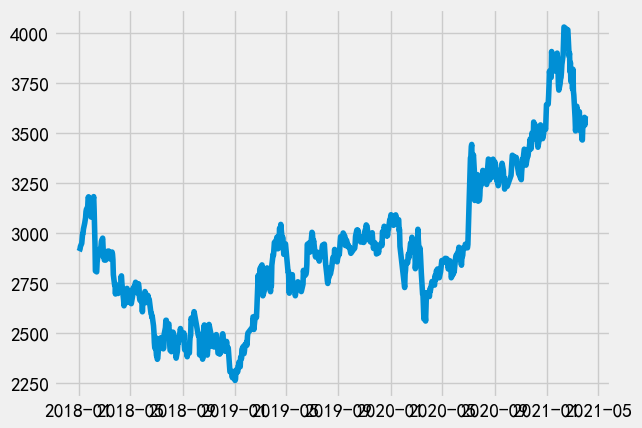

In [17]:
plt.plot(index_data_all.loc[backtest_start: backtest_end, 'close'])

In [19]:
output[output['敲入敲出状态']=="敲入，未敲出"]

,初始日期,初始指数,到期日期,到期指数,敲入日期,敲入点位,敲出日期,敲出点位,敲入敲出状态,敲出所需时间（月）,绝对收益率,年化收益率,完成周期
9,2018-01-15,3048.8075,2020-01-15,3058.0078,2018-06-28,2425.1758,None,None,敲入，未敲出,None,0.003018,0.001509,True
10,2018-01-16,3063.8609,2020-01-16,3043.0931,2018-06-28,2425.1758,None,None,敲入，未敲出,None,-0.006778,-0.003389,True
11,2018-01-17,3076.1819,2020-01-17,3053.1729,2018-06-27,2452.6386,None,None,敲入，未敲出,None,-0.00748,-0.00374,True
12,2018-01-18,3106.5516,2020-01-20,3065.9906,2018-06-27,2452.6386,None,None,敲入，未敲出,None,-0.013057,-0.006528,True
13,2018-01-19,3117.8212,2020-01-20,3065.9906,2018-06-27,2452.6386,None,None,敲入，未敲出,None,-0.016624,-0.008312,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,2021-03-26,3529.7282,2023-03-27,2639.6226,2022-03-15,2702.8532,None,None,敲入，未敲出,None,-0.2,-0.1,True
785,2021-03-29,3537.711,2023-03-29,2636.2229,2022-03-15,2702.8532,None,None,敲入，未敲出,None,-0.2,-0.1,True
786,2021-03-30,3577.2434,2023-03-30,2664.2119,2022-03-14,2851.8769,None,None,敲入，未敲出,None,-0.2,-0.1,True
787,2021-03-31,3539.3696,2023-03-31,2661.9197,2022-03-15,2702.8532,None,None,敲入，未敲出,None,-0.2,-0.1,True


In [39]:
index_data_selected = snowball.get_index_data_selected(data)

In [40]:
start_date = snowball.time_dynamic_param["start_date"]
end_date = snowball.time_dynamic_param["end_date"]

snowball.start_price = index_data_selected.loc[start_date, "close"]  # 起始日标的价格
snowball.end_price = index_data_selected.loc[end_date, "close"]  # 结束日标的价格
observation_period = [
    i
    for i in list(index_data_selected.index)
    if i > start_date and i <= end_date
]  # 回测区间



In [42]:
snowball.knockin_param["knockin_barrier"]

0.8

In [41]:
snowball.start_price * snowball.knockin_param["knockin_barrier"]

2323.38544

In [33]:
for current_date in observation_period:
    current_price = index_data_selected.loc[current_date, "close"]
    if current_price <= round(
        snowball.start_price * snowball.knockin_param["knockin_barrier"], 2
    ):  # 发生敲入
        snowball.knockin_date = current_date
        snowball.knockin_price = current_price
        return None
self.knockin_date = None
self.knockin_price = None

yes


In [34]:
snowball.knockout_param["knockout_barrier"]

-1.3800000000000003

In [27]:
index_data_selected.loc[snowball.knockout_date]

close    2484.7318
Name: 2021-07-01, dtype: float64

In [26]:
snowball.knockout_date

datetime.date(2021, 7, 1)

In [22]:
output

,初始日期,初始指数,到期日期,到期指数,敲入日期,敲入点位,敲出日期,敲出点位,敲入敲出状态,敲出所需时间（月）,绝对收益率,年化收益率,完成周期
0,2018-01-02,2908.7318,2020-01-02,2665.2318,None,None,2018-04-02,2879.2318,未敲入，敲出,3,0.03,0.12,True
1,2018-01-03,2908.2318,2020-01-03,2664.7318,None,None,2018-04-03,2878.7318,未敲入，敲出,3,0.03,0.12,True
2,2018-01-04,2907.7318,2020-01-06,2664.2318,None,None,2018-04-04,2878.2318,未敲入，敲出,3,0.03,0.12,True
3,2018-01-05,2907.2318,2020-01-06,2664.2318,None,None,2018-04-09,2877.7318,未敲入，敲出,3,0.03,0.12,True
4,2018-01-08,2906.7318,2020-01-08,2663.2318,None,None,2018-04-09,2877.7318,未敲入，敲出,3,0.03,0.12,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,2021-03-26,2516.7318,2023-03-27,2274.2318,None,None,2021-06-28,2486.2318,未敲入，敲出,3,0.03,0.12,True
785,2021-03-29,2516.2318,2023-03-29,2273.2318,None,None,2021-06-29,2485.7318,未敲入，敲出,3,0.03,0.12,True
786,2021-03-30,2515.7318,2023-03-30,2272.7318,None,None,2021-06-30,2485.2318,未敲入，敲出,3,0.03,0.12,True
787,2021-03-31,2515.2318,2023-03-31,2272.2318,None,None,2021-06-30,2485.2318,未敲入，敲出,3,0.03,0.12,True
